# 1. Kaggle data

Kaggle can provide us with a ton of datasets. We will be using the official kaggle api to automate our data fetching process.

1. Log on to kaggle and enter the [How good is your Medium article?](https://www.kaggle.com/c/how-good-is-your-medium-article) competition.
2. Configure the official kaggle api [following these steps](https://github.com/Kaggle/kaggle-api).

For this tutorial we will need only 1 file.
```bash
kaggle competitions download -c how-good-is-your-medium-article -f train.json.gz

```

The reason for decompressing will become clear later.

```bash
gunzip -k ~/.kaggle/competitions/how-good-is-your-medium-article/train.json.gz
```

# 2. Exploration.

Despite the extension being json our data is stored as [jsonl](http://jsonlines.org/). This means that each line of `train.json` is a valid json file.

```bash
head -n1 ~/.kaggle/competitions/how-good-is-your-medium-article/train.json | jq 'del(.content)'
```
```json
{
  "_id": "https://medium.com/policy/medium-terms-of-service-9db0094a1e0f",
  "_timestamp": 1520035195.282891,
  "_spider": "medium",
  "url": "https://medium.com/policy/medium-terms-of-service-9db0094a1e0f",
  "domain": "medium.com",
  "published": {
    "$date": "2012-08-13T22:54:53.510Z"
  },
  "title": "Medium Terms of Service – Medium Policy – Medium",
  "author": {
    "name": null,
    "url": "https://medium.com/@Medium",
    "twitter": "@Medium"
  },
  "image_url": null,
  "tags": [],
  "link_tags": {
    "canonical": "https://medium.com/policy/medium-terms-of-service-9db0094a1e0f",
    "publisher": "https://plus.google.com/103654360130207659246",
    "author": "https://medium.com/@Medium",
    "search": "/osd.xml",
    "alternate": "android-app://com.medium.reader/https/medium.com/p/9db0094a1e0f",
    "stylesheet": "https://cdn-static-1.medium.com/_/fp/css/main-branding-base.Ch8g7KPCoGXbtKfJaVXo_w.css",
    "icon": "https://cdn-static-1.medium.com/_/fp/icons/favicon-rebrand-medium.3Y6xpZ-0FSdWDnPM3hSBIA.ico",
    "apple-touch-icon": "https://cdn-images-1.medium.com/fit/c/120/120/1*6_fgYnisCa9V21mymySIvA.png",
    "mask-icon": "https://cdn-static-1.medium.com/_/fp/icons/monogram-mask.KPLCSFEZviQN0jQ7veN2RQ.svg"
  },
  "meta_tags": {
    "viewport": "width=device-width, initial-scale=1",
    "title": "Medium Terms of Service – Medium Policy – Medium",
    "referrer": "unsafe-url",
    "description": "These Terms of Service (“Terms”) are a contract between you and A Medium Corporation. They govern your use of Medium’s sites, services, mobile apps, products, and content (“Services”). By using…",
    "theme-color": "#000000",
    "og:title": "Medium Terms of Service – Medium Policy – Medium",
    "og:url": "https://medium.com/policy/medium-terms-of-service-9db0094a1e0f",
    "fb:app_id": "542599432471018",
    "og:description": "These Terms of Service (“Terms”) are a contract between you and A Medium Corporation. They govern your use of Medium’s sites, services, mobile apps, products, and content (“Services”). By using…",
    "twitter:description": "These Terms of Service (“Terms”) are a contract between you and A Medium Corporation. They govern your use of Medium’s sites, services, mobile apps, products, and content (“Services”). By using…",
    "author": "Medium",
    "og:type": "article",
    "twitter:card": "summary",
    "article:publisher": "https://www.facebook.com/medium",
    "article:author": "https://medium.com/@Medium",
    "robots": "index, follow",
    "article:published_time": "2012-08-13T22:54:53.510Z",
    "twitter:creator": "@Medium",
    "twitter:site": "@Medium",
    "og:site_name": "Medium",
    "twitter:label1": "Reading time",
    "twitter:data1": "5 min read",
    "twitter:app:name:iphone": "Medium",
    "twitter:app:id:iphone": "828256236",
    "twitter:app:url:iphone": "medium://p/9db0094a1e0f",
    "al:ios:app_name": "Medium",
    "al:ios:app_store_id": "828256236",
    "al:android:package": "com.medium.reader",
    "al:android:app_name": "Medium",
    "al:ios:url": "medium://p/9db0094a1e0f",
    "al:android:url": "medium://p/9db0094a1e0f",
    "al:web:url": "https://medium.com/policy/medium-terms-of-service-9db0094a1e0f"
  }
}
```

I've ommited the `content` field due to it's huge verbosity. Our problem requires that we use the fields `published.$date` and `meta_tags.twitter:data`.

```bash
head -n10 train.json | jq '[.published["$date"], .meta_tags["twitter:data1"]] | @csv' -r
```
```
"2012-08-13T22:54:53.510Z","5 min read"
"2015-08-03T07:44:50.331Z","7 min read"
"2017-02-05T13:08:17.410Z","2 min read"
"2017-05-06T08:16:30.776Z","3 min read"
"2017-06-04T14:46:25.772Z","4 min read"
"2017-04-02T16:21:15.171Z","7 min read"
"2016-08-15T04:16:02.103Z","12 min read"
"2015-01-14T21:31:07.568Z","5 min read"
"2014-02-11T04:11:54.771Z","4 min read"
"2015-10-25T02:58:05.551Z","8 min read"
```

# 3. The good, the bad and the ugly solutions

In [1]:
%matplotlib inline

In [3]:
import json
import pandas as pd
import os
import dask.bag as db

HOME = os.environ['HOME']
train_file = f'{HOME}/.kaggle/competitions/how-good-is-your-medium-article/train.json'
MEGABYTES = 1024**2

## The Ugly

In [4]:
def make_datum(x):
    return {
        'published_timestamp': x['published']['$date'],
        'read_time': x['meta_tags']['twitter:data1']
    }

with open(train_file, 'r') as f:    
    ugly_df = pd.DataFrame([make_datum(json.loads(x)) for x in f])
ugly_df.head()

,published_timestamp,read_time
0,2012-08-13T22:54:53.510Z,5 min read
1,2015-08-03T07:44:50.331Z,7 min read
2,2017-02-05T13:08:17.410Z,2 min read
3,2017-05-06T08:16:30.776Z,3 min read
4,2017-06-04T14:46:25.772Z,4 min read


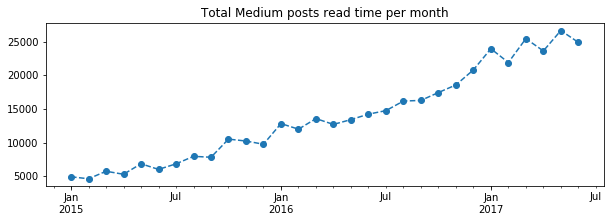

In [6]:
(
    ugly_df
    .assign(read_time = lambda x: x['read_time'].str.split(' ').str[0])
    .astype({
        'published_timestamp': 'datetime64[ns]',
        'read_time': int
    })
    .set_index('published_timestamp')
    ['read_time']
    ['2015':]
    .groupby(lambda index: pd.to_datetime(index.strftime('%Y-%m')))
    .sum()
    .plot(style='o--', figsize=(10,3), title='Total Medium posts read time per month')
);

## The Good

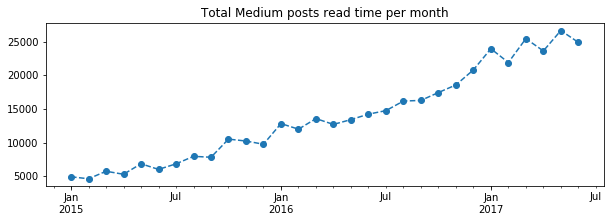

In [8]:
(
    db
    .read_text(train_file, blocksize=10*MEGABYTES)
    .map(json.loads)
    .map(lambda x: {
        'published_timestamp': x['published']['$date'],
        'read_time': x['meta_tags']['twitter:data1'].split(' ')[0]
    })
    .to_dataframe({
        'published_timestamp': 'datetime64[ns]',
        'read_time': int
    })
    .compute()
    .set_index('published_timestamp')
    ['read_time']
    ['2015':]
    .groupby(lambda index: pd.to_datetime(index.strftime('%Y-%m')))
    .sum()
    .plot(style='o--', figsize=(10,3), title='Total Medium posts read time per month')
);